# Elden Ring: The Architecture of Fate

## Complete Research Pipeline

This notebook combines the entire research workflow: Data Collection, Graph Construction, Network Analysis, and NLP Analysis.

# Section: 01_data_collection.ipynb

# 01. Data Collection (Week 1)

## Week 1: APIs & Data Acquisition

**Research Question:** "To what extent do game mechanics (specifically stat scaling and item utility) dictate the narrative topology and character fates of the Elden Ring universe?"

### Course Concepts Applied
-   **APIs:** Interacting with the Elden Ring Fan API.
-   **Data Handling:** Pagination, Rate Limiting, and Caching (JSON).
-   **Reproducibility:** Creating a robust data pipeline.

**Endpoints:** `items`, `weapons`, `npcs`, `locations`, `bosses`, `armors`, `talismans`, `incantations`.

In [1]:
import datetime as dt
import json
import sys
import time
from pathlib import Path
from typing import Dict, List, Sequence

import requests

CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parents[1]]
PROJECT_ROOT = None
for candidate in CANDIDATES:
    # Relaxed check: Look for 'scripts' OR 'requirements.txt' to identify root.
    # We don't check for 'data' because it might not exist yet if running from scratch.
    if (candidate / "scripts").exists() or (candidate / "requirements.txt").exists():
        PROJECT_ROOT = candidate.resolve()
        break

if PROJECT_ROOT is None:
    print(f"Debug: Current Working Directory is {Path.cwd()}")
    raise RuntimeError("Could not locate project root. Ensure 'scripts/' or 'requirements.txt' exists in the project root.")

# Ensure data directory structure exists (create if missing)
(PROJECT_ROOT / "data").mkdir(exist_ok=True)
RAW_DIR = PROJECT_ROOT / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw cache: {RAW_DIR}")

Project root: C:\social_graphs_project
Raw cache: C:\social_graphs_project\data\raw


In [2]:
BASE_URL = "https://eldenring.fanapis.com/api"
ENDPOINTS = [
    "items",
    "weapons",
    "npcs",
    "locations",
    "bosses",
    "armors",
    "talismans",
    "incantations",
    "classes" # Added classes endpoint
]
PAGE_SIZE = 100
RATE_LIMIT_SECONDS = 0.25
FORCE_REFRESH = False  # Set to True to force fresh data download (User requested "from scratch")

if FORCE_REFRESH:
    import shutil
    print("⚠️ FORCE_REFRESH enabled: Wiping existing data to ensure a clean slate.")
    
    # 1. Clean API Data (RAW_DIR is defined in previous cell)
    if RAW_DIR.exists():
        shutil.rmtree(RAW_DIR)
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    print(f"   - Recreated {RAW_DIR}")

    # 2. Clean Scraped Data
    scraped_dir = PROJECT_ROOT / "data" / "scraped"
    if scraped_dir.exists():
        shutil.rmtree(scraped_dir)
    scraped_dir.mkdir(parents=True, exist_ok=True)
    print(f"   - Recreated {scraped_dir}")

    # 3. Clean Processed Data
    processed_dir = PROJECT_ROOT / "data" / "processed"
    if processed_dir.exists():
        shutil.rmtree(processed_dir)
    processed_dir.mkdir(parents=True, exist_ok=True)
    print(f"   - Recreated {processed_dir}")
else:
    print("✅ FORCE_REFRESH disabled: Using existing cached data if available.")

✅ FORCE_REFRESH disabled: Using existing cached data if available.


In [3]:
session = requests.Session()
session.headers.update({"User-Agent": "MarwanProposal/1.0"})

def fetch_endpoint(endpoint: str) -> List[dict]:
    page = 0
    records: List[dict] = []
    while True:
        params = {"limit": PAGE_SIZE, "page": page}
        response = session.get(f"{BASE_URL}/{endpoint}", params=params, timeout=30)
        if response.status_code != 200:
            raise RuntimeError(f"Request failed for {endpoint} page {page}: {response.status_code}")
        payload = response.json()
        rows = payload.get("data", [])
        if not rows:
            break
        records.extend(rows)
        total = payload.get("total")
        if total is not None and len(records) >= int(total):
            break
        page += 1
        time.sleep(RATE_LIMIT_SECONDS)
    return records

def write_cache(endpoint: str, rows: Sequence[dict]) -> Path:
    target = RAW_DIR / f"{endpoint}.json"
    if target.exists() and not FORCE_REFRESH:
        print(f"[cache] {target} already exists; skipping (set FORCE_REFRESH=True to overwrite).")
        return target
    target.write_text(json.dumps(rows, indent=2), encoding="utf-8")
    print(f"[saved] {target} ({len(rows)} rows)")
    return target

In [4]:
provenance = []
timestamp = dt.datetime.utcnow().isoformat() + "Z"
for endpoint in ENDPOINTS:
    print(f"[fetch] {endpoint}")
    rows = fetch_endpoint(endpoint)
    cache_path = write_cache(endpoint, rows)
    provenance.append({"endpoint": endpoint, "rows": len(rows), "cache_path": str(cache_path)})

summary_path = RAW_DIR / "provenance.json"
summary_payload = {"fetched_at": timestamp, "endpoints": provenance}
summary_path.write_text(json.dumps(summary_payload, indent=2), encoding="utf-8")
print(f"[done] wrote provenance to {summary_path}")


[fetch] items
[cache] C:\social_graphs_project\data\raw\items.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] weapons
[cache] C:\social_graphs_project\data\raw\items.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] weapons
[cache] C:\social_graphs_project\data\raw\weapons.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] npcs
[cache] C:\social_graphs_project\data\raw\weapons.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] npcs
[cache] C:\social_graphs_project\data\raw\npcs.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] locations
[cache] C:\social_graphs_project\data\raw\npcs.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] locations
[cache] C:\social_graphs_project\data\raw\locations.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] bosses
[cache] C:\social_graphs_project\data\raw\locations.

In [5]:
import pandas as pd
from IPython.display import display

df = pd.DataFrame(provenance)
display(df)

,endpoint,rows,cache_path
0,items,462,C:\social_graphs_project\data\raw\items.json
1,weapons,307,C:\social_graphs_project\data\raw\weapons.json
2,npcs,55,C:\social_graphs_project\data\raw\npcs.json
3,locations,177,C:\social_graphs_project\data\raw\locations.json
4,bosses,106,C:\social_graphs_project\data\raw\bosses.json
5,armors,568,C:\social_graphs_project\data\raw\armors.json
6,talismans,87,C:\social_graphs_project\data\raw\talismans.json
7,incantations,98,C:\social_graphs_project\data\raw\incantations...
8,classes,14,C:\social_graphs_project\data\raw\classes.json


In [6]:
"""
Scrape Elden Ring Wiki (Fextralife) for comprehensive data.

Usage
-----
python scripts/scrape_wiki.py --categories bosses npcs --delay 0.5

This script crawls the Fextralife wiki to gather detailed information including
lore, descriptions, and stats that might be missing from the standard API.
"""
import argparse
import json
import sys
import time
import re
from pathlib import Path
from typing import List, Dict, Set
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup

BASE_URL = "https://eldenring.wiki.fextralife.com"

# Mapping of logical names to Wiki URLs
CATEGORY_URLS = {
    "bosses": "/Bosses",
    "npcs": "/NPCs",
    "weapons": "/Weapons",
    "armor": "/Armor",
    "talismans": "/Talismans",
    "locations": "/Locations",
    "creatures": "/Creatures+and+Enemies",
    "ashes": "/Ash+of+War",
    "spirits": "/Spirit+Ashes",
    "items": "/Items",
    "lore": "/Lore"
}

# Detect project root (works if CWD is project root or if running from notebooks/ subdir)
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

CACHE_DIR = project_root / "data" / "scraped"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

def clean_text(text: str) -> str:
    """Clean whitespace and unwanted characters from text."""
    if not text:
        return ""
    return re.sub(r'\s+', ' ', text).strip()

def get_soup(url: str, session: requests.Session) -> BeautifulSoup:
    """Fetch a URL and return a BeautifulSoup object."""
    try:
        response = session.get(url, headers=HEADERS, timeout=30)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}", file=sys.stderr)
        return None

def extract_links_from_category(category_path: str, session: requests.Session) -> List[str]:
    """Extract all relevant wiki page links from a category page."""
    url = urljoin(BASE_URL, category_path)
    print(f"Scanning category: {url}")
    soup = get_soup(url, session)
    if not soup:
        return []

    links = set()

    # Fextralife usually puts lists in tables or specific divs
    # We look for links in the main content area
    content_div = soup.find('div', {'id': 'wiki-content-block'})
    if not content_div:
        print("Could not find content block.")
        return []

    for a_tag in content_div.find_all('a', href=True):
        href = a_tag['href']
        # Filter out irrelevant links (anchors, external, special pages)
        if href.startswith('/') and not href.startswith('/file/') and ':' not in href:
            # Avoid the category page itself or simple variations
            if href.lower() != category_path.lower():
                links.add(href)

    return sorted(list(links))

def scrape_page(page_path: str, session: requests.Session) -> Dict:
    """Scrape content from a single wiki page."""
    url = urljoin(BASE_URL, page_path)
    soup = get_soup(url, session)
    if not soup:
        return None

    data = {
        "url": url,
        "name": "",
        "image": None,
        "description": "",
        "content": [],
        "infobox": {}
    }

    # Extract Name (usually the page title or h1)
    # Fextralife titles often have " | Elden Ring Wiki"
    title_tag = soup.find('title')
    if title_tag:
        data['name'] = title_tag.get_text().split('|')[0].strip()

    content_div = soup.find('div', {'id': 'wiki-content-block'})
    if not content_div:
        return data

    # Extract Image (first significant image in content)
    img = content_div.find('img')
    if img and img.get('src'):
        data['image'] = urljoin(BASE_URL, img['src'])

    # Extract Infobox data (table with class 'wiki_table')
    infobox = content_div.find('table', {'class': 'wiki_table'})
    if infobox:
        for row in infobox.find_all('tr'):
            cols = row.find_all(['th', 'td'])
            if len(cols) >= 2:
                key = clean_text(cols[0].get_text())
                val = clean_text(cols[1].get_text())
                if key and val:
                    data['infobox'][key] = val

    # Extract text content (paragraphs)
    # We skip the infobox and other tables for the main text
    for elem in content_div.find_all(['p', 'h2', 'h3', 'ul']):
        # Skip if inside a table
        if elem.find_parent('table'):
            continue

        text = clean_text(elem.get_text())
        if text:
            data['content'].append(text)

    # Join first few paragraphs as description
    if data['content']:
        data['description'] = data['content'][0]

    return data

def main():
    parser = argparse.ArgumentParser(description="Scrape Elden Ring Wiki")
    parser.add_argument("--categories", nargs="+", default=list(CATEGORY_URLS.keys()),
                        help=f"Categories to scrape. Options: {', '.join(CATEGORY_URLS.keys())}")
    parser.add_argument("--delay", type=float, default=0.5, help="Delay between requests in seconds")
    parser.add_argument("--limit", type=int, default=None, help="Limit number of pages per category (for testing)")
    
    # In a notebook, sys.argv will contain kernel args, so we pass empty list to use defaults
    # or you can manually specify args here like: args = parser.parse_args(['--limit', '5'])
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
        print("Running in Notebook mode. Using default arguments (all categories).")
        print("To limit, edit the args in the cell: parser.parse_args(['--limit', '5'])")
    else:
        args = parser.parse_args()

    CACHE_DIR.mkdir(parents=True, exist_ok=True)
    session = requests.Session()

    for category in args.categories:
        if category not in CATEGORY_URLS:
            print(f"Unknown category: {category}. Skipping.")
            continue

        print(f"\n--- Processing Category: {category} ---")
        page_links = extract_links_from_category(CATEGORY_URLS[category], session)
        print(f"Found {len(page_links)} pages in {category}.")

        results = []
        count = 0

        for link in page_links:
            if args.limit and count >= args.limit:
                break

            print(f"Scraping [{count+1}/{len(page_links)}]: {link}")
            page_data = scrape_page(link, session)
            if page_data:
                page_data['category'] = category
                results.append(page_data)

            count += 1
            time.sleep(args.delay)

        # Save results
        output_file = CACHE_DIR / f"{category}.json"
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        print(f"Saved {len(results)} items to {output_file}")

if __name__ == "__main__":
    main()

Running in Notebook mode. Using default arguments (all categories).
To limit, edit the args in the cell: parser.parse_args(['--limit', '5'])

--- Processing Category: bosses ---
Scanning category: https://eldenring.wiki.fextralife.com/Bosses
Found 603 pages in bosses.
Scraping [1/603]: /<span+id=
Found 603 pages in bosses.
Scraping [1/603]: /<span+id=


Error fetching https://eldenring.wiki.fextralife.com/<span+id=: 404 Client Error: Not Found for url: https://eldenring.wiki.fextralife.com/%3Cspan+id=


Scraping [2/603]: /Abandoned+Cave
Scraping [3/603]: /Abductor+Virgins
Scraping [3/603]: /Abductor+Virgins
Scraping [4/603]: /Abyssal+Woods
Scraping [4/603]: /Abyssal+Woods
Scraping [5/603]: /Academy+Crystal+Cave
Scraping [5/603]: /Academy+Crystal+Cave
Scraping [6/603]: /Adan,+Thief+of+Fire
Scraping [6/603]: /Adan,+Thief+of+Fire
Scraping [7/603]: /Adula's+Moonblade
Scraping [7/603]: /Adula's+Moonblade
Scraping [8/603]: /Ainsel+River
Scraping [8/603]: /Ainsel+River
Scraping [9/603]: /Alecto+Black+Knife+Ringleader
Scraping [9/603]: /Alecto+Black+Knife+Ringleader
Scraping [10/603]: /Alecto,+Black+Knife+Ringleader
Scraping [10/603]: /Alecto,+Black+Knife+Ringleader
Scraping [11/603]: /All-Knowing+Set
Scraping [11/603]: /All-Knowing+Set
Scraping [12/603]: /Altus+Plateau
Scraping [12/603]: /Altus+Plateau
Scraping [13/603]: /Ancestor+Spirit
Scraping [13/603]: /Ancestor+Spirit
Scraping [14/603]: /Ancestral+Follower+Ashes
Scraping [14/603]: /Ancestral+Follower+Ashes
Scraping [15/603]: /Ancient+Dr

Error fetching https://eldenring.wiki.fextralife.com/Church+District: 404 Client Error: Not Found for url: https://eldenring.wiki.fextralife.com/Shadow+Keep%23ChurchDistrict


Scraping [90/603]: /Church+of+Anticipation
Scraping [91/603]: /Church+of+Vows
Scraping [91/603]: /Church+of+Vows
Scraping [92/603]: /Cleanrot+Knight
Scraping [92/603]: /Cleanrot+Knight
Scraping [93/603]: /Coastal+Cave
Scraping [93/603]: /Coastal+Cave
Scraping [94/603]: /Commander's+Standard
Scraping [94/603]: /Commander's+Standard
Scraping [95/603]: /Commander+Gaius
Scraping [95/603]: /Commander+Gaius
Scraping [96/603]: /Commander+Niall
Scraping [96/603]: /Commander+Niall
Scraping [97/603]: /Commander+O'Neil
Scraping [97/603]: /Commander+O'Neil
Scraping [98/603]: /Consecrated+Snowfield
Scraping [98/603]: /Consecrated+Snowfield
Scraping [99/603]: /Consecrated+Snowfield+Catacombs
Scraping [99/603]: /Consecrated+Snowfield+Catacombs
Scraping [100/603]: /Count+Ymir,+Mother+of+Fingers
Scraping [100/603]: /Count+Ymir,+Mother+of+Fingers
Scraping [101/603]: /Creatures+and+Enemies
Scraping [101/603]: /Creatures+and+Enemies
Scraping [102/603]: /Crimson+Amber+Medallion
Scraping [102/603]: /Crimson

Error fetching https://eldenring.wiki.fextralife.com/Margit,+the+Fell+Omen.: 404 Client Error: Not Found for url: https://eldenring.wiki.fextralife.com/Margit,+the+Fell+Omen.


Scraping [380/553]: /Marika's+Scarseal
Scraping [381/553]: /Marika's+Soreseal
Scraping [381/553]: /Marika's+Soreseal
Scraping [382/553]: /Memory+Slots
Scraping [382/553]: /Memory+Slots
Scraping [383/553]: /Memory+Stone
Scraping [383/553]: /Memory+Stone
Scraping [384/553]: /Merchants
Scraping [384/553]: /Merchants
Scraping [385/553]: /Millicent
Scraping [385/553]: /Millicent
Scraping [386/553]: /Millicent's+Prosthesis
Scraping [386/553]: /Millicent's+Prosthesis
Scraping [387/553]: /Mimic+Tear
Scraping [387/553]: /Mimic+Tear
Scraping [388/553]: /Mind
Scraping [388/553]: /Mind
Scraping [389/553]: /Miquella's+Haligtree
Scraping [389/553]: /Miquella's+Haligtree
Scraping [390/553]: /Miranda+the+Blighted+Bloom
Scraping [390/553]: /Miranda+the+Blighted+Bloom
Scraping [391/553]: /Misbegotten+Warrior
Scraping [391/553]: /Misbegotten+Warrior
Scraping [392/553]: /Mistwood+Ruins
Scraping [392/553]: /Mistwood+Ruins
Scraping [393/553]: /Mohgwyn+Palace
Scraping [393/553]: /Mohgwyn+Palace
Scraping [394

Error fetching https://eldenring.wiki.fextralife.com/Ash+of+War: 404 Client Error: Not Found for url: https://eldenring.wiki.fextralife.com/Ash+of+War


Found 0 pages in ashes.
Saved 0 items to c:\social_graphs_project\data\scraped\ashes.json

--- Processing Category: spirits ---
Scanning category: https://eldenring.wiki.fextralife.com/Spirit+Ashes
Found 122 pages in spirits.
Scraping [1/122]: /Albinauric+Ashes
Found 122 pages in spirits.
Scraping [1/122]: /Albinauric+Ashes
Scraping [2/122]: /Ancestral+Follower+Ashes
Scraping [2/122]: /Ancestral+Follower+Ashes
Scraping [3/122]: /Ancient+Dragon+Florissax
Scraping [3/122]: /Ancient+Dragon+Florissax
Scraping [4/122]: /Ancient+Dragon+Knight+Kristoff+Ashes
Scraping [4/122]: /Ancient+Dragon+Knight+Kristoff+Ashes
Scraping [5/122]: /Archer+Ashes
Scraping [5/122]: /Archer+Ashes
Scraping [6/122]: /Avionette+Soldier+Ashes
Scraping [6/122]: /Avionette+Soldier+Ashes
Scraping [7/122]: /Azula+Beastman+Ashes
Scraping [7/122]: /Azula+Beastman+Ashes
Scraping [8/122]: /Banished+Knight+Engvall+Ashes
Scraping [8/122]: /Banished+Knight+Engvall+Ashes
Scraping [9/122]: /Banished+Knight+Oleg+Ashes
Scraping [9/

## 1.1 Supplementary Data: Wiki Scraping

To enrich our dataset, we scrape the Fextralife Wiki for detailed lore descriptions, stats, and image links that might be missing or sparse in the standard API. This ensures we have the "deepest" possible text data for our NLP analysis.

**Note:** This process can take time. By default, it scrapes all configured categories.


# Section: 02_graph_construction.ipynb

# 02. Graph Construction (Week 2)

## Week 2: Graph Theory & NetworkX

This notebook processes the raw API data into a multimodal graph that captures the structural mechanics of the game.

### Course Concepts Applied
-   **Nodes & Edges:** Defining what constitutes a node (Item, NPC) and an edge (Drop, Location).
-   **Attributes:** Attaching metadata (Scaling, Bell Bearings) to nodes for later analysis.
-   **Graph Construction:** Building the network structure from tabular data.

### Outputs
-   `data/processed/nodes.csv`: Canonical node table.
-   `data/processed/edges.csv`: Multimodal relationships.

In [7]:
import json
import re
import pandas as pd
import networkx as nx
from pathlib import Path
from typing import List, Dict, Set, Tuple
from dataclasses import dataclass, asdict
from itertools import combinations
import os

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================

# Detect project root (works if CWD is project root or if running from notebooks/ subdir)
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

API_DIR = project_root / "data" / "raw"
WIKI_DIR = project_root / "data" / "scraped"
PROCESSED_DIR = project_root / "data" / "processed"

# Create output directory
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {project_root}")
print(f"API Data: {API_DIR}")
print(f"Wiki Data: {WIKI_DIR}")

# Map Wiki filenames to Node Types
WIKI_FILES = {
    "armor.json": "armor",
    "bosses.json": "boss",
    "npcs.json": "npc",
    "weapons.json": "weapon"
}

# API Endpoints
API_ENDPOINTS = [
    "items", "weapons", "npcs", "locations",
    "bosses", "armors", "talismans", "incantations"
]

@dataclass
class NodeRecord:
    node_id: str
    node_type: str
    name: str
    description: str
    source: str
    metadata: dict

@dataclass
class EdgeRecord:
    source: str
    target: str
    relationship: str
    edge_type: str
    metadata: dict

# ==========================================
# 2. HELPER FUNCTIONS (From Original Notebook)
# ==========================================

def normalize_name(name):
    if not name: return None
    # Lowercase, strip, remove special chars
    return name.lower().strip().replace("'", "").replace("-", " ")

def clean_text(value: str) -> str:
    if not value: return ""
    return re.sub(r"\s+", " ", value).strip()

def explode_locations(raw_value: str) -> List[str]:
    """Splits location strings into individual location names."""
    if not raw_value: return []
    if not isinstance(raw_value, str): return []

    seps = [",", "/", " and ", " & ", ";"]
    parts = [raw_value]
    for sep in seps:
        nxt = []
        for part in parts:
            nxt.extend(part.split(sep))
        parts = nxt
    return [p.strip() for p in parts if p.strip()]

def load_json_safe(path):
    if not path.exists():
        print(f"  ❌ File not found: {path}")
        return []
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"  ⚠️ Error loading {path.name}: {e}")
        return []

# ==========================================
# 3. DATA LOADING & MERGING
# ==========================================

def build_merged_nodes():
    nodes_map = {}

    print("\n--- Loading API Data ---")
    for endpoint in API_ENDPOINTS:
        data = load_json_safe(API_DIR / f"{endpoint}.json")
        for item in data:
            name = item.get("name")
            if not name: continue
            norm_name = normalize_name(name)

            n_type = endpoint[:-1] if endpoint.endswith('s') else endpoint
            nodes_map[norm_name] = NodeRecord(
                node_id=item.get("id") or f"api_{norm_name.replace(' ', '_')}",
                node_type=n_type,
                name=name,
                description=clean_text(item.get("description") or item.get("effect")),
                source="api",
                metadata={k:v for k,v in item.items() if k not in ['id', 'name', 'description', 'effect']}
            )

    print("\n--- Loading Wiki Data ---")
    for filename, n_type in WIKI_FILES.items():
        data = load_json_safe(WIKI_DIR / filename)
        for item in data:
            name = item.get("name")
            if not name: continue
            norm_name = normalize_name(name)

            infobox = item.get("infobox", {})
            wiki_desc = clean_text(item.get("description"))

            if norm_name in nodes_map:
                existing = nodes_map[norm_name]
                if wiki_desc and wiki_desc not in existing.description:
                    existing.description = (existing.description + " " + wiki_desc).strip()
                existing.metadata.update(infobox)
                existing.metadata['wiki_url'] = item.get("url")
                existing.source = "merged"
            else:
                nodes_map[norm_name] = NodeRecord(
                    node_id=f"wiki_{norm_name.replace(' ', '_')}",
                    node_type=n_type,
                    name=name,
                    description=wiki_desc,
                    source="wiki",
                    metadata=infobox
                )

    return list(nodes_map.values())

# ==========================================
# 4. EDGE GENERATION (RESTORED LOGIC)
# ==========================================

def build_edges(nodes: List[NodeRecord]):
    edges = []
    node_lookup = {normalize_name(n.name): n.node_id for n in nodes}
    location_ids = {n.node_id for n in nodes if n.node_type == 'location'}

    print("\n--- Generating Edges ---")

    # 1. EXPLICIT EDGES (Location & Drops)
    print("Processing Explicit Edges (Found In / Drops)...")
    for node in nodes:
        # A. Location Edges
        # Check both API 'location' and Wiki 'Location' fields
        loc_str = node.metadata.get("location") or node.metadata.get("Location")
        if loc_str:
            # Use explode_locations to handle lists like "Limgrave, Stormhill"
            possible_locs = explode_locations(str(loc_str))
            for loc_name in possible_locs:
                norm_loc = normalize_name(loc_name)
                # Try direct match
                target_id = node_lookup.get(norm_loc)

                # If no direct match, try fuzzy matching against known locations
                if not target_id:
                     for known_loc_name, known_loc_id in node_lookup.items():
                        if known_loc_id in location_ids and known_loc_name in norm_loc:
                            target_id = known_loc_id
                            break

                if target_id and target_id in location_ids:
                    edges.append(EdgeRecord(node.node_id, target_id, "found_in", "location", {}))

        # B. Drops Edges
        drops = node.metadata.get("drops") or []
        if isinstance(drops, list):
            for drop_name in drops:
                drop_id = node_lookup.get(normalize_name(drop_name))
                if drop_id:
                    edges.append(EdgeRecord(node.node_id, drop_id, "drops", "drop", {}))

    # 2. SHARED LOCATION EDGES (Restored from Original)
    # Connects Bosses/NPCs that are in the same location bucket
    print("Processing Shared Location Edges...")
    loc_buckets: Dict[str, List[str]] = {}

    for node in nodes:
        # Only group Characters (Bosses, NPCs)
        if node.node_type not in ['boss', 'npc']:
            continue

        loc_str = node.metadata.get("location") or node.metadata.get("Location")
        if loc_str:
            for loc in explode_locations(str(loc_str)):
                norm = normalize_name(loc)
                if norm:
                    loc_buckets.setdefault(norm, []).append(node.node_id)

    for loc_name, node_ids in loc_buckets.items():
        # If multiple chars are in this location, connect them
        if len(node_ids) > 1:
            # Sort to ensure unique pairs
            for a, b in combinations(sorted(set(node_ids)), 2):
                edges.append(EdgeRecord(a, b, "share_location", "share_location", {"location": loc_name}))

    # 3. MENTIONS (Restored Broad Scope)
    # Check if ANY node name appears in ANY node description
    print("Processing Mention Edges (NLP)...")

    # Filter short names to avoid noise (e.g., "Map", "Key")
    searchable_names = {name: nid for name, nid in node_lookup.items() if len(name) >= 5}

    for node in nodes:
        desc = (node.description or "").lower()
        if not desc: continue

        # Check against all searchable names
        for target_name, target_id in searchable_names.items():
            if target_id == node.node_id: continue # No self-loops

            if target_name in desc:
                edges.append(EdgeRecord(node.node_id, target_id, "mentions", "mention", {}))

    return edges

# ==========================================
# 5. EXECUTION
# ==========================================

nodes = build_merged_nodes()

if not nodes:
    print("❌ Critical Error: No nodes loaded. Verify your paths!")
else:
    print(f"Nodes Loaded: {len(nodes)}")

    edges = build_edges(nodes)
    print(f"Edges Created: {len(edges)}")

    node_df = pd.DataFrame([asdict(n) for n in nodes])
    edge_df = pd.DataFrame([asdict(e) for e in edges])

    # JSON serialize metadata
    if 'metadata' in node_df.columns:
        node_df['metadata'] = node_df['metadata'].apply(lambda x: json.dumps(x, ensure_ascii=False))
    if 'metadata' in edge_df.columns:
        edge_df['metadata'] = edge_df['metadata'].apply(lambda x: json.dumps(x, ensure_ascii=False))

    node_df.to_csv(PROCESSED_DIR / "nodes_enriched.csv", index=False)
    edge_df.to_csv(PROCESSED_DIR / "edges_enriched.csv", index=False)
    print(f"✅ Saved enriched graph to {PROCESSED_DIR}")

Project Root: c:\social_graphs_project
API Data: c:\social_graphs_project\data\raw
Wiki Data: c:\social_graphs_project\data\scraped

--- Loading API Data ---

--- Loading Wiki Data ---

--- Loading Wiki Data ---
Nodes Loaded: 2515

--- Generating Edges ---
Processing Explicit Edges (Found In / Drops)...
Processing Shared Location Edges...
Processing Mention Edges (NLP)...
Nodes Loaded: 2515

--- Generating Edges ---
Processing Explicit Edges (Found In / Drops)...
Processing Shared Location Edges...
Processing Mention Edges (NLP)...
Edges Created: 5679
Edges Created: 5679
✅ Saved enriched graph to c:\social_graphs_project\data\processed
✅ Saved enriched graph to c:\social_graphs_project\data\processed


# Section: 03_network_analysis.ipynb

# 03. Network Analysis (Weeks 3-5)

## Analyzing the Architecture of Fate

This notebook performs the core network science analysis, mapping directly to the course curriculum.

### Course Concepts Applied
1.  **Week 5: Community Detection (The Bipolar World)**
    -   **Method:** Louvain Algorithm.
    -   **Application:** Quantifying the structural split between Int and Faith.
2.  **Week 4: Centrality (The Tragedy of Utility)**
    -   **Method:** Betweenness Centrality.
    -   **Application:** Identifying "Tragic Hubs" (Merchants).
3.  **Week 3: Network Structure (The Illusion of Choice)**
    -   **Method:** Shortest Paths & Assortativity.
    -   **Application:** Measuring the "cost" of endings and the segregation of items.

In [ ]:
import pandas as pd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"

NODES_PATH = PROCESSED_DIR / "nodes_enriched.csv"
EDGES_PATH = PROCESSED_DIR / "edges_enriched.csv"
OUTPUT_PATH = PROCESSED_DIR / "nodes_analyzed.csv"

print(f"Loading data from: {PROCESSED_DIR}")

# ==========================================
# 2. BUILD GRAPH
# ==========================================
nodes_df = pd.read_csv(NODES_PATH)
edges_df = pd.read_csv(EDGES_PATH)

print(f"Nodes loaded: {len(nodes_df)}")
print(f"Edges loaded: {len(edges_df)}")

# Initialize Graph
G = nx.Graph()

# Add Nodes
for _, row in nodes_df.iterrows():
    # We treat 'node_id' as the unique identifier
    G.add_node(row['node_id'],
               name=row['name'],
               type=row['node_type'],
               description=str(row['description']))

# Add Edges
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'],
               relation=row['relationship'],
               type=row['edge_type'])

print(f"Original Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# ==========================================
# 3. FILTERING: CREATE G_CLEAN (Lore-Only)
# ==========================================
print("\n--- Applying Lore-Only Filter ---")

# Define Stop-List of Game Mechanic Nodes
MECHANIC_NODES = [
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Standard", "Pierce", "Slash", "Strike", 
    "Physical", "Magic", "Fire", "Lightning", "Holy", 
    "Attributes", "Required", "Scales With", "fp", "stamina",
    "Remembrance", "Memory Slot", "Talisman Pouch", "Golden Seed",
    "Sacred Tear", "Larval Tear", "Lost Ashes of War", "Smithing Stone",
    "Somber Smithing Stone", "Glovewort", "Bell Bearing"
]

# Create G_clean
G_clean = G.copy()

# Identify nodes to remove (checking by name)
nodes_to_remove = []
for node_id, data in G_clean.nodes(data=True):
    # Check exact match or if the name contains "Remembrance of" (optional, but safer to stick to list first)
    if data.get('name') in MECHANIC_NODES:
        nodes_to_remove.append(node_id)

G_clean.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} mechanic nodes.")
print(f"Clean Graph: {G_clean.number_of_nodes()} nodes, {G_clean.number_of_edges()} edges.")

# ==========================================
# 4. TOPOLOGY DIAGNOSTICS
# ==========================================
print("\n--- Topology Diagnostics ---")

# Node Count Drop
drop_count = G.number_of_nodes() - G_clean.number_of_nodes()
print(f"Node Count Drop: {drop_count}")

# Giant Component Analysis
if len(G_clean) > 0:
    largest_cc = max(nx.connected_components(G_clean), key=len)
    giant_size = len(largest_cc)
    total_nodes = len(G_clean)
    ratio = giant_size / total_nodes
else:
    giant_size = 0
    ratio = 0

print(f"Giant Component Size: {giant_size} ({ratio:.1%})")

# Scenario Verdict
if ratio < 0.30:
    verdict = "Scenario A ('Dust Cloud'): < 30% of nodes in Giant Component (Graph collapsed)."
elif 0.30 <= ratio <= 0.60:
    verdict = "Scenario B ('Regional Factions'): 30-60% of nodes in Giant Component."
else:
    verdict = "Scenario C ('Hidden Network'): > 60% of nodes in Giant Component."

print(f"VERDICT: {verdict}")

# ==========================================
# 5. RE-RUN METRICS ON G_CLEAN
# ==========================================

# Community Detection (Louvain) on G_clean
print("\n--- Re-running Community Detection (Louvain) on G_clean ---")
communities = nx.community.louvain_communities(G_clean, seed=42)
partition = {}
for i, comm_nodes in enumerate(communities):
    for node in comm_nodes:
        partition[node] = i

# Update DataFrame with new community
# Nodes not in G_clean will get NaN
nodes_df['community'] = nodes_df['node_id'].map(partition)

print(f"New Community Count: {len(communities)}")

# Centrality Analysis on G_clean
print("\n--- Re-running Betweenness Centrality on G_clean ---")
betweenness = nx.betweenness_centrality(G_clean)
nodes_df['centrality'] = nodes_df['node_id'].map(betweenness).fillna(0)

# Show Top 10 Narrative Bridges
print("\nTop 10 Narrative Bridges (Lore-Only):")
print(nodes_df[nodes_df['node_id'].isin(G_clean.nodes())][['name', 'node_type', 'centrality']]
      .sort_values('centrality', ascending=False)
      .head(10))

# ==========================================
# 6. EXPORT RESULTS
# ==========================================
nodes_df.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Analysis Complete. Saved results to: {OUTPUT_PATH}")

Loading data from: c:\social_graphs_project\data\processed
Nodes loaded: 2515
Edges loaded: 5679
Original Graph constructed: 2515 nodes, 5537 edges.

--- Applying Lore-Only Filter ---
Removed 3 mechanic nodes.
Clean Graph: 2512 nodes, 4691 edges.

--- Topology Diagnostics ---
Node Count Drop: 3
Giant Component Size: 1986 (79.1%)
VERDICT: Scenario C ('Hidden Network'): > 60% of nodes in Giant Component.

--- Re-running Community Detection (Louvain) on G_clean ---
Original Graph constructed: 2515 nodes, 5537 edges.

--- Applying Lore-Only Filter ---
Removed 3 mechanic nodes.
Clean Graph: 2512 nodes, 4691 edges.

--- Topology Diagnostics ---
Node Count Drop: 3
Giant Component Size: 1986 (79.1%)
VERDICT: Scenario C ('Hidden Network'): > 60% of nodes in Giant Component.

--- Re-running Community Detection (Louvain) on G_clean ---
New Community Count: 526

--- Re-running Betweenness Centrality on G_clean ---
New Community Count: 526

--- Re-running Betweenness Centrality on G_clean ---

Top 

# Section: 04_nlp_analysis.ipynb

# 04. NLP Analysis (Weeks 6-7)

## The Semantic Layer

This notebook complements the network analysis by examining the textual content of item descriptions and dialogue.

### Course Concepts Applied
1.  **Week 6: Text Analysis (TF-IDF)**
    -   **Method:** Term Frequency-Inverse Document Frequency.
    -   **Application:** Extracting distinct vocabularies for the "Int" vs. "Faith" factions.
2.  **Week 7: Sentiment Analysis**
    -   **Method:** Lexical Sentiment / Keyword Counting.
    -   **Application:** Quantifying the "Tragedy of Commerce" by counting death-related terms in merchant descriptions.

Loading analyzed data from: c:\social_graphs_project\data\processed\nodes_analyzed.csv

--- Calculating Sentiment ---
Most Negative Descriptions (The Tragic):
                           name  sentiment
982              Alabaster Lord       -1.0
1047              Lion Guardian       -1.0
231                     Rot Pot       -1.0
768   Bloody Finger Hunter Yura       -0.8
1999         Vulgar Militia Set       -0.7

Most Positive Descriptions (The Noble/Divine):
                                name  sentiment
1690                    Radagon Icon        1.0
1707                    Godfrey Icon        1.0
1101  Beast Champion Armor (altered)        1.0
1713               Marika's Soreseal        1.0
1692              Radagon's Soreseal        1.0

Average Sentiment by Node Type:
node_type
item           0.005685
npc            0.006497
location       0.015900
armor          0.060098
boss           0.118702
bosse          0.121864
talisman       0.125999
incantation    0.130092
weapon      

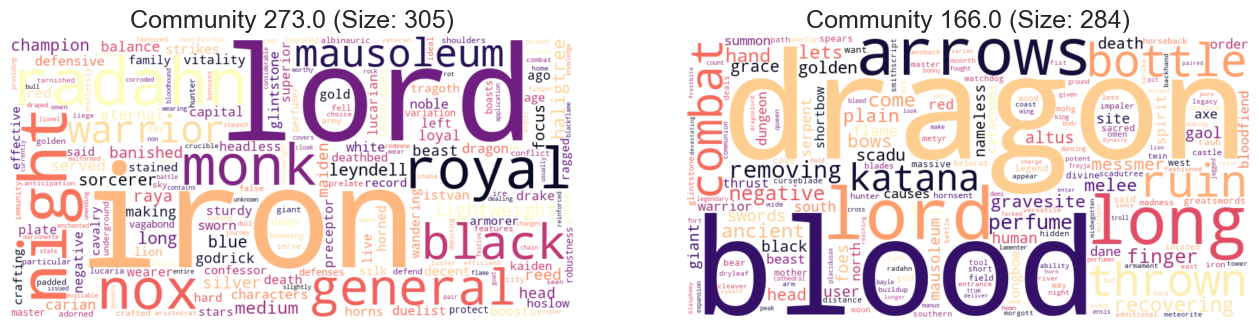

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS # requires: pip install wordcloud

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "nodes_analyzed.csv"

print(f"Loading analyzed data from: {INPUT_PATH}")
df = pd.read_csv(INPUT_PATH)

# -------------------------------------------------------
# CONSISTENCY FIX: APPLY SAME NOISE FILTER
# We remove generic categories to ensure NLP/Sentiment reflects true lore.
# -------------------------------------------------------
noise_list = [
    # Stats & Mechanics
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Stats", "Runes", "Poison", "Scarlet Rot", "Status Effects",
    "Standard", "Pierce", "Slash", "Strike", 
    "Physical", "Magic", "Fire", "Lightning", "Holy",
    "Passive", "Skill", "Effect",
    
    # Item Categories (The "Gauntlets" Problem)
    "Armor", "Weapons", "Bosses", "Items", "Ash of War",
    "Gauntlets", "Greaves", "Helm", "Chest", "Legs", "Shield", 
    "Talisman", "Sorcery", "Incantation", "Spirit Ash",
    
    # Upgrades & Collectibles
    "Remembrance", "Memory Slot", "Talisman Pouch", "Golden Seed",
    "Sacred Tear", "Larval Tear", "Lost Ashes of War", "Smithing Stone",
    "Somber Smithing Stone", "Glovewort", "Bell Bearing",
    
    # World Terms
    "Shadow of the Erdtree", "The Lands Between"
]
df = df[~df['name'].isin(noise_list)]
print(f"Filtered Data: {len(df)} nodes remaining after noise removal.")

# Ensure description is string (handle NaNs from raw data)
df['description'] = df['description'].astype(str).fillna("")

# ==========================================
# 2. SENTIMENT ANALYSIS (Mood of the World)
# ==========================================
print("\n--- Calculating Sentiment ---")

def get_sentiment(text):
    # Skip very short text to avoid noise
    if len(text) < 5: return 0
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# Show "Tragic" vs "Noble" items
print("Most Negative Descriptions (The Tragic):")
print(df[['name', 'sentiment']].sort_values('sentiment').head(5))

print("\nMost Positive Descriptions (The Noble/Divine):")
print(df[['name', 'sentiment']].sort_values('sentiment', ascending=False).head(5))

# Average sentiment by type
print("\nAverage Sentiment by Node Type:")
print(df.groupby('node_type')['sentiment'].mean().sort_values())

# ==========================================
# 3. COMMUNITY KEYWORD EXTRACTION (Identifying Factions) - FILTERED
# ==========================================
print("\n--- Identifying Community Themes ---")

# 1. Define Custom Stop Words (Consolidated List)
# Start with standard English stop words
base_stopwords = list(ENGLISH_STOP_WORDS)

# Basic Game Terms
game_terms = [
    "elden", "ring", "player", "players", "target", "attack", "attacks",
    "damage", "effect", "increase", "stat", "attribute",
    "character", "enemy", "enemies", "found", "location",
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting", 
    "items", "npc", "boss", "bosses", "shadow", "erdtree", "dlc", "two", "three",
    "remembrance", "remembrances",
    "buff", "buffs", "debuff", "debuffs", "range", "ranged", "reach",
    "defeat", "defeated", "defeating", "obtain", "obtained", "obtaining",
    "drop", "drops", "dropped", "reward", "rewards", "rewarded",
    "game", "games", "playthrough", "mode", "multiplayer", "online",
    "wield", "wielded", "wielder", "wielding", "require", "requires", "requiring",
    "optional", "added", "need", "needs", "use", "uses", "using", 
    "properties", "inflicting", "advance", "temporary", "certain", "typically", "various",
    # Wiki & Meta
    "note", "notes", "tip", "tips", "strategy", "strategies", "guide", "walkthrough", 
    "wiki", "edit", "page", "patch", "update", "regulation", "pvp", "pve", 
    "farm", "farming", "drop", "rate", "chance", "guaranteed",
    # Mechanics & Comparatives
    "stack", "stacks", "stacking", "duration", "second", "seconds", "minute", "minutes", 
    "cooldown", "speed", "cast", "casting", "time", "slot", "slots",
    "high", "higher", "highest", "low", "lower", "lowest", 
    "fast", "faster", "fastest", "slow", "slower", "slowest",
    "best", "worst", "better", "worse", "strong", "stronger", "weak", "weaker"
]

# Strict Lore Filter (Banning generic RPG terms)
lore_filter = [
    # 1. ARMOR GENERIC TERMS
    "helm", "helms", "helmet", "helmets", "chest", "piece", "pieces", "set", "sets", 
    "gauntlets", "gauntlet", "leg", "legs", "greaves", "boots",
    "armor", "armour", "shield", "attire", "garb", "robe", "hood", 
    "cloth", "leather", "metal", "worn", "protection", "defense", 
    "weight", "light", "lighter", "heavy", "heavier", "poise", 
    "negation", "composed", "version", "appearance", "standard",
    "soldier", "soldiers", "knight", "knights", "foot", "generic", "surcoat",

    # 2. MECHANIC & STAT TERMS
    "scale", "scales", "scaling", "grade", "attribute", "attributes",
    "strength", "dexterity", "intelligence", "faith", "arcane",
    "str", "dex", "int", "fai", "arc", "build", "builds", "stat", "status",
    "required", "requirement", "requires", "primarily", "good", "great",
    "weapon", "weapons", "sword", "spear", "bow", "arrow", "bolt",
    "staff", "seal", "talisman", "tear", "crystal", "phys", "physical", "magic", "magical", 
    "fire", "lightning", "holy", "guard", "boost", "effect", "effects",
    "skill", "ash", "war", "affinity", "affinities", "attack", "power", "damage",
    "deal", "inflict", "cause", "apply", "applying", "passive", "grant",
    "restore", "restores", "restorative", "fp", "hp", "stamina", "cost", "consume", "consumables",
    "upgrade", "material", "smithing", "stone", "bell", "bearing",
    "resistance", "resistances", "colossal", "piercing", "slash", "strike",
    "unique", "powerful", "exclusive", "special", "base", "max", "min",
    
    # 3. GENERIC VERBS & FILLER
    "found", "location", "area", "map", "region", "world", "land",
    "use", "used", "using", "able", "capable", "allow", "allows",
    "provide", "provides", "offer", "offers", "various", "different",
    "typically", "highly", "vast", "small", "large", "new", "old",
    "added", "add", "brand", "brandish", "brandished", "type", "types", "variety"
]

# Combine all stop words
full_stop_words_list = base_stopwords + game_terms + lore_filter
# Remove duplicates
full_stop_words_list = list(set(full_stop_words_list))

# 2. Aggregate text per community
community_docs = df.groupby('community')['description'].apply(lambda x: " ".join(x))

# 3. Run TF-IDF with Custom Stop Words
# stop_words=full_stop_words_list: Tells the model to completely ignore the words above
tfidf = TfidfVectorizer(stop_words=full_stop_words_list, max_df=0.6, max_features=1000)
tfidf_matrix = tfidf.fit_transform(community_docs)
feature_names = tfidf.get_feature_names_out()

# Helper to get top words for a specific community ID
def get_keywords(comm_id, top_n=8):
    if comm_id not in community_docs.index: return []
    row_idx = list(community_docs.index).index(comm_id)
    row = tfidf_matrix[row_idx]
    sorted_items = sorted(zip(row.indices, row.data), key=lambda x: x[1], reverse=True)[:top_n]
    return [feature_names[i] for i, score in sorted_items]

# 4. Print the List of Major Communities
top_communities = df['community'].value_counts().head(10).index.tolist()

print(f"{'ID':<5} | {'Size':<6} | {'Defining Keywords (The Vibe)'}")
print("-" * 80)

for comm_id in top_communities:
    size = len(df[df['community'] == comm_id])
    keywords = get_keywords(comm_id)
    kw_str = ", ".join(keywords)
    print(f"{comm_id:<5} | {size:<6} | {kw_str}")

# ==========================================
# 4. VISUALIZATION (Word Clouds) - FILTERED
# ==========================================
print("\n--- Generating Word Clouds for Top 2 Factions ---")

# Use the SAME list for WordCloud (convert to set)
wc_stopwords = set(STOPWORDS).union(set(full_stop_words_list))

plt.figure(figsize=(16, 8))

# Loop through top 2 communities
for i, comm_id in enumerate(top_communities[:2]):
    # FORCE LOWERCASE to ensure stop words match exactly
    text = community_docs.loc[comm_id].lower()

    # 2. Pass the stopwords to the generator
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',    # <--- CHANGED TO WHITE
        colormap='magma',            # <--- CHANGED TO MAGMA (Better contrast on white)
        stopwords=wc_stopwords,
        collocations=False
    ).generate(text)

    plt.subplot(1, 2, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {comm_id} (Size: {len(df[df['community']==comm_id])})")

plt.show()

# Topology of the shattering (topological fragmentation 3.1)

Graph Constructed: 2497 nodes, 3498 edges.

Generating Figure 1: The Mathematical Topology (All Clusters)...


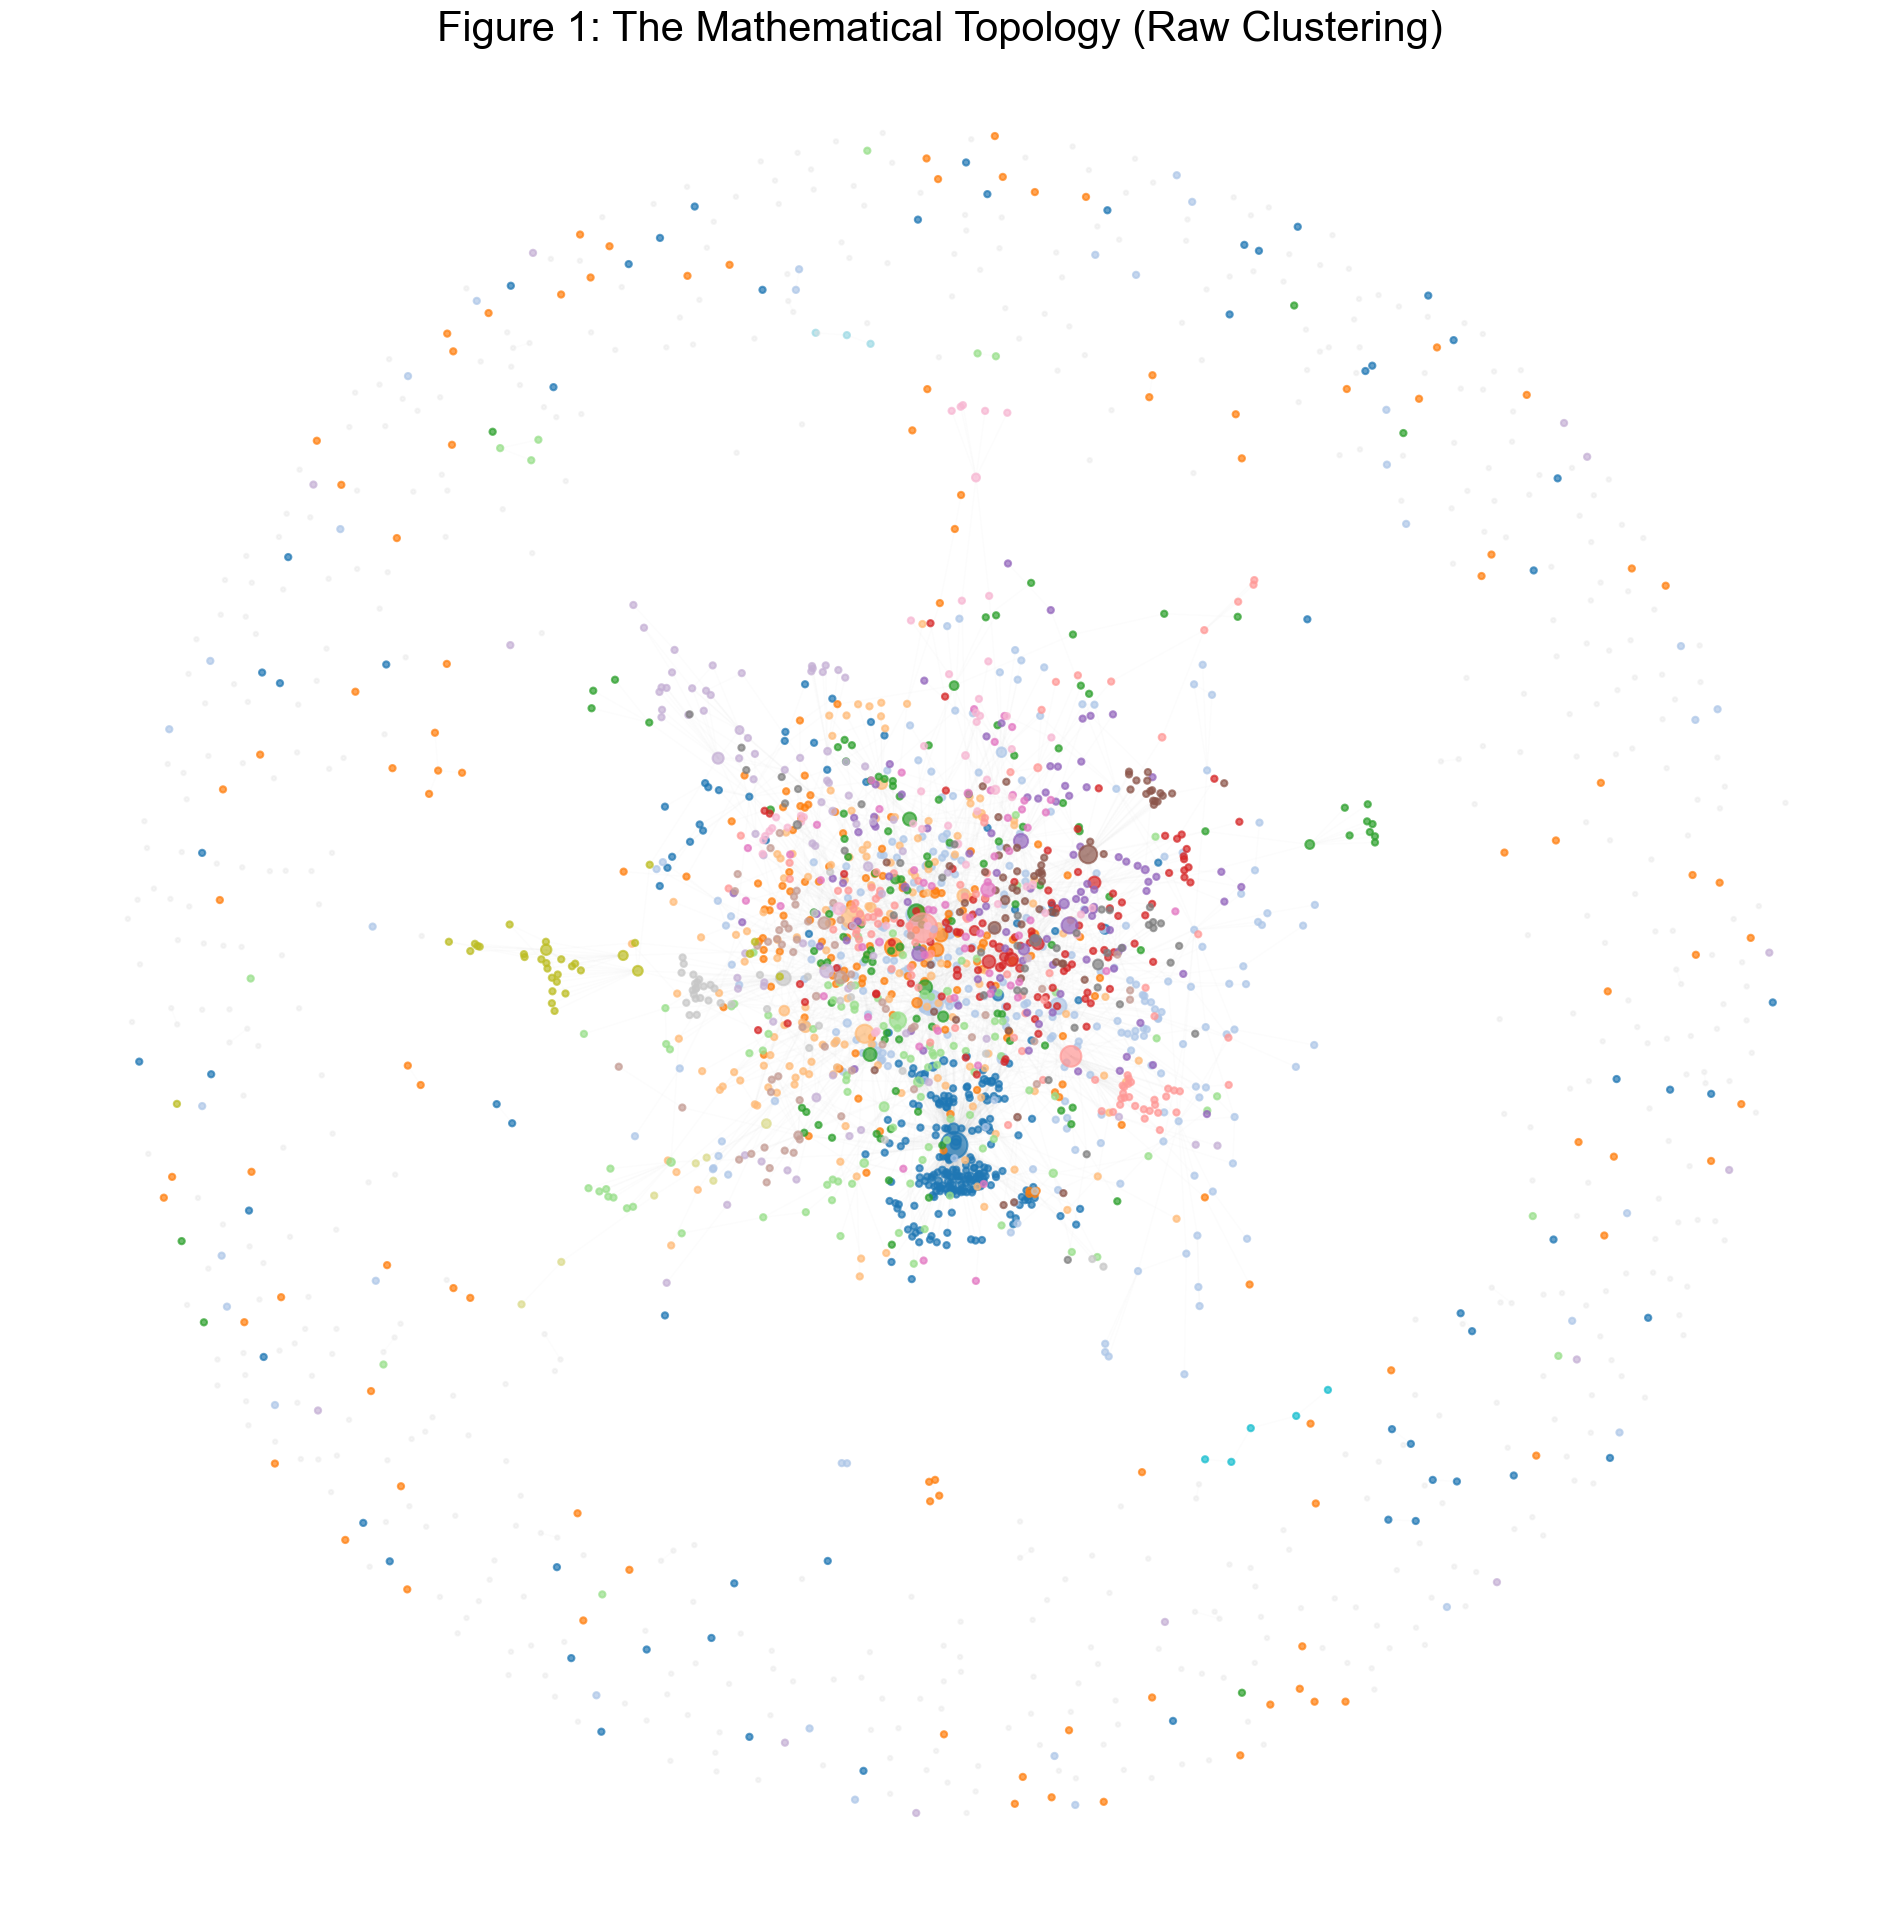


Generating Figure 2: The Six Great Factions (Canonical Mapping)...


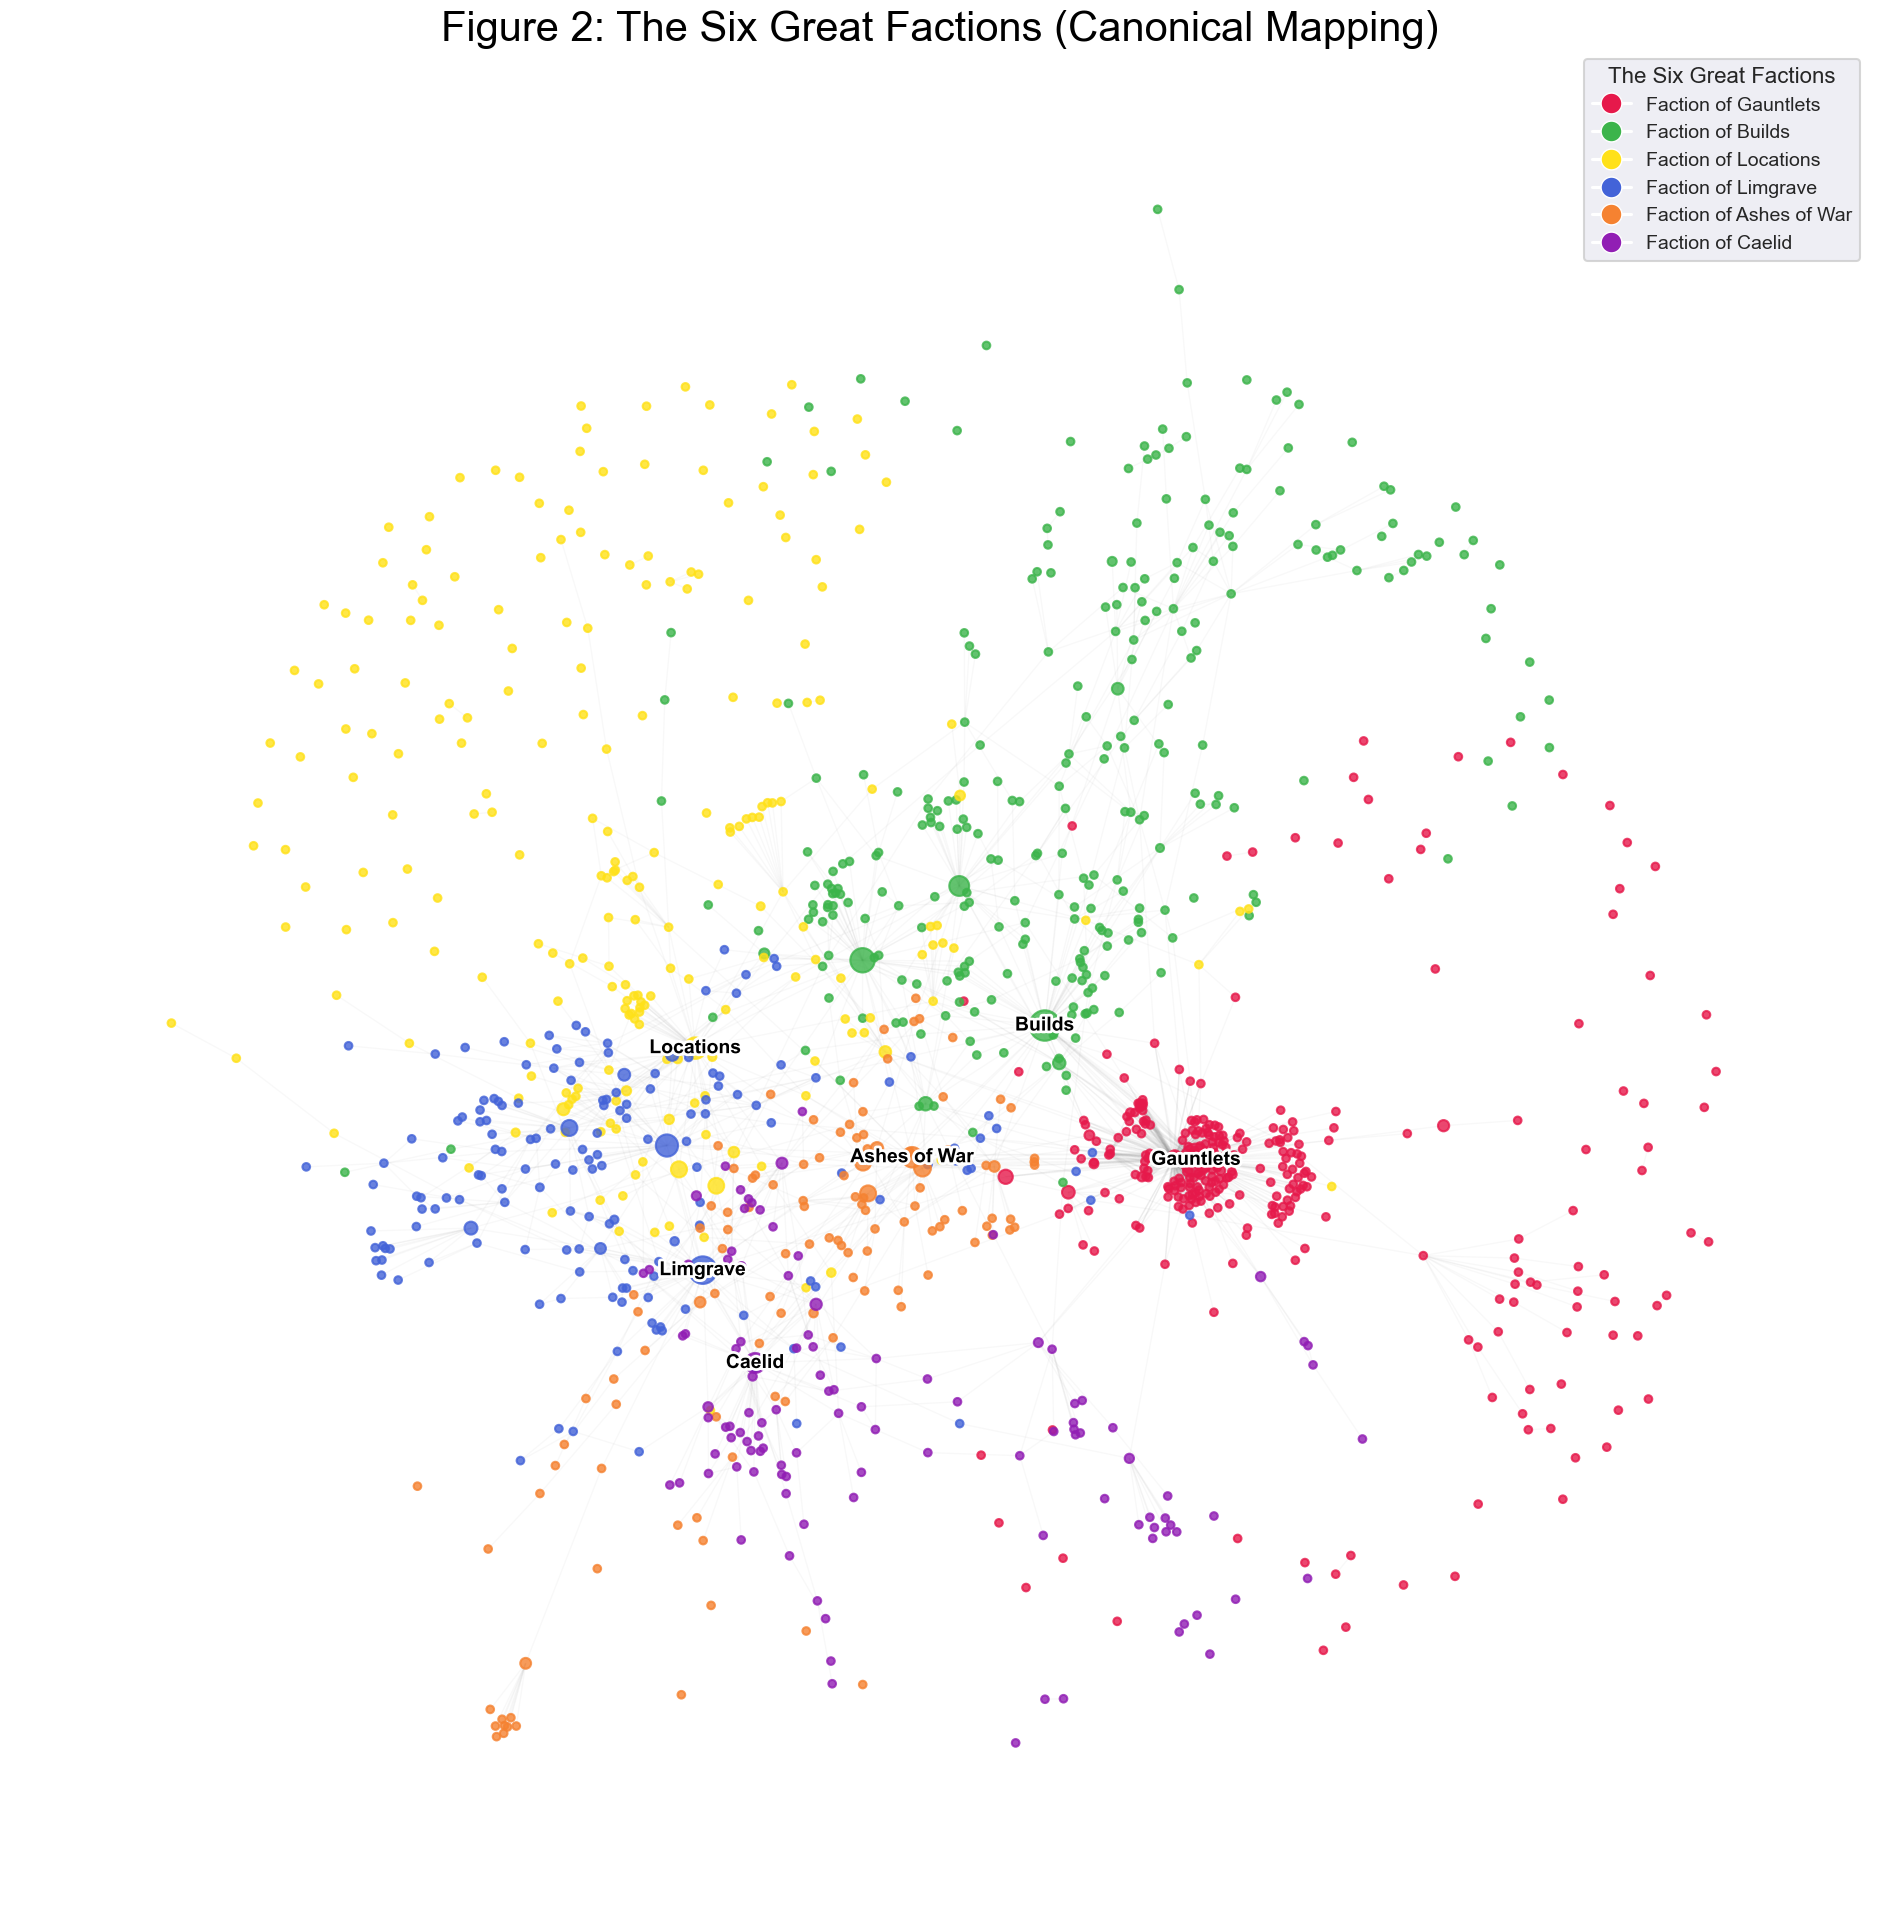

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
from pathlib import Path

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
nodes = pd.read_csv(PROCESSED_DIR / "nodes_analyzed.csv")
edges = pd.read_csv(PROCESSED_DIR / "edges_enriched.csv")

# Filter Noise (Updated with comprehensive list)
noise_list = [
    # Stats & Mechanics
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Stats", "Runes", "Poison", "Scarlet Rot", "Status Effects",
    "Standard", "Pierce", "Slash", "Strike", 
    "Physical", "Magic", "Fire", "Lightning", "Holy",
    "Passive", "Skill", "Effect",
    
    # Item Categories (The "Gauntlets" Problem)
    "Armor", "Weapons", "Bosses", "Items", "Ash of War",
    "Gauntlets", "Greaves", "Helm", "Chest", "Legs", "Shield", 
    "Talisman", "Sorcery", "Incantation", "Spirit Ash",
    
    # Upgrades & Collectibles
    "Remembrance", "Memory Slot", "Talisman Pouch", "Golden Seed",
    "Sacred Tear", "Larval Tear", "Lost Ashes of War", "Smithing Stone",
    "Somber Smithing Stone", "Glovewort", "Bell Bearing",
    
    # World Terms
    "Shadow of the Erdtree", "The Lands Between"
]
nodes_clean = nodes[~nodes['name'].isin(noise_list)]
valid_ids = set(nodes_clean['node_id'])

# Rebuild Graph
G_vis = nx.Graph()
for _, row in nodes_clean.iterrows():
    G_vis.add_node(row['node_id'], community=row['community'], size=row['centrality'])

for _, row in edges.iterrows():
    if row['source'] in valid_ids and row['target'] in valid_ids:
        G_vis.add_edge(row['source'], row['target'])

# Map ID to Name
id_to_name = dict(zip(nodes_clean['node_id'], nodes_clean['name']))

print(f"Graph Constructed: {G_vis.number_of_nodes()} nodes, {G_vis.number_of_edges()} edges.")

# ==========================================
# FIGURE 1: THE ACTUAL RESULTS (Full Topology)
# ==========================================
print("\nGenerating Figure 1: The Mathematical Topology (All Clusters)...")

plt.figure(figsize=(24, 24), facecolor='white')

# 1. Layout (Unconstrained Spring)
# This shows the "actual" shape of the network without forcing it into a ring
pos_full = nx.spring_layout(G_vis, k=0.15, iterations=50, seed=42)

# 2. Colors (Top 20)
comm_counts = nodes_clean['community'].value_counts()
top_20_comms = comm_counts.head(20).index.tolist()
palette = plt.cm.tab20.colors 

# Draw Faint Edges
nx.draw_networkx_edges(G_vis, pos_full, alpha=0.05, edge_color='lightgrey')

# Draw Nodes (Top 20)
for i, comm_id in enumerate(top_20_comms):
    nodelist = [n for n in G_vis.nodes() if G_vis.nodes[n]['community'] == comm_id]
    sizes = [max(20, G_vis.nodes[n]['size'] * 10000) for n in nodelist]
    nx.draw_networkx_nodes(
        G_vis, pos_full, nodelist=nodelist,
        node_color=[palette[i % len(palette)]],
        node_size=sizes, alpha=0.7
    )

# Draw Minor Nodes (Grey)
minor_nodes = [n for n in G_vis.nodes() if G_vis.nodes[n]['community'] not in top_20_comms]
if minor_nodes:
    sizes = [max(10, G_vis.nodes[n]['size'] * 10000) for n in minor_nodes]
    nx.draw_networkx_nodes(
        G_vis, pos_full, nodelist=minor_nodes,
        node_color='#E0E0E0', node_size=sizes, alpha=0.3
    )

plt.title("Figure 1: The Mathematical Topology (Raw Clustering)", fontsize=30, color='black')
plt.axis('off')
plt.show()

# ==========================================
# FIGURE 2: THE CANONICAL FACTIONS (Top 6 + Heroes)
# ==========================================
print("\nGenerating Figure 2: The Six Great Factions (Canonical Mapping)...")

# 1. Identify Top 6 & Heroes
top_6_ids = comm_counts.head(6).index.tolist()
faction_labels = {}
faction_heroes = {}

for comm_id in top_6_ids:
    comm_nodes = [n for n in G_vis.nodes() if G_vis.nodes[n]['community'] == comm_id]
    hero_node = max(comm_nodes, key=lambda n: G_vis.nodes[n]['size'])
    hero_name = id_to_name.get(hero_node, hero_node)
    faction_labels[comm_id] = f"Faction of {hero_name}"
    faction_heroes[comm_id] = hero_node

# 2. Filter Graph
nodes_of_interest = [n for n in G_vis.nodes() if G_vis.nodes[n]['community'] in top_6_ids]
G_focused = G_vis.subgraph(nodes_of_interest)

# 3. Ring Layout
pos_ring = {}
angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)
radius = 3.0

for i, comm_id in enumerate(top_6_ids):
    center = (radius * np.cos(angles[i]), radius * np.sin(angles[i]))
    comm_nodes = [n for n in G_focused.nodes() if G_focused.nodes[n]['community'] == comm_id]
    for node in comm_nodes:
        pos_ring[node] = np.array(center) + np.random.rand(2) * 0.5

pos_ring = nx.spring_layout(G_focused, pos=pos_ring, k=0.2, iterations=50, seed=42)

# 4. Draw
plt.figure(figsize=(24, 24), facecolor='white')
colors_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4']
comm_color_map = dict(zip(top_6_ids, colors_list))

nx.draw_networkx_edges(G_focused, pos_ring, alpha=0.05, edge_color='grey')

legend_handles = []
for comm_id in top_6_ids:
    nodelist = [n for n in G_focused.nodes() if G_focused.nodes[n]['community'] == comm_id]
    sizes = [max(30, G_focused.nodes[n]['size'] * 15000) for n in nodelist]
    nx.draw_networkx_nodes(
        G_focused, pos_ring, nodelist=nodelist,
        node_color=comm_color_map[comm_id], node_size=sizes, alpha=0.8
    )
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=faction_labels[comm_id],
                          markerfacecolor=comm_color_map[comm_id], markersize=15))

# Labels (Heroes Only)
text_items = {faction_heroes[c]: id_to_name.get(faction_heroes[c]) for c in top_6_ids}
text_objects = nx.draw_networkx_labels(
    G_focused, pos_ring, labels=text_items,
    font_size=14, font_weight='bold', font_color='black'
)
for t in text_objects.values():
    t.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])

plt.legend(handles=legend_handles, loc='upper right', fontsize=14, title="The Six Great Factions", title_fontsize=16)
plt.title("Figure 2: The Six Great Factions (Canonical Mapping)", fontsize=30, color='black')
plt.axis('off')
plt.show()

### Golden order propaganda 3.2

Filtered Data: 2496 nodes remaining after noise removal.
Calculating sentiment for visualization...


C:\Users\marwa\AppData\Local\Temp\ipykernel_27424\359256569.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Category', y='sentiment', data=plot_df,


Filtered Data: 2488 nodes remaining after noise removal.
Calculating sentiment for visualization...


C:\Users\marwa\AppData\Local\Temp\ipykernel_27424\359256569.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


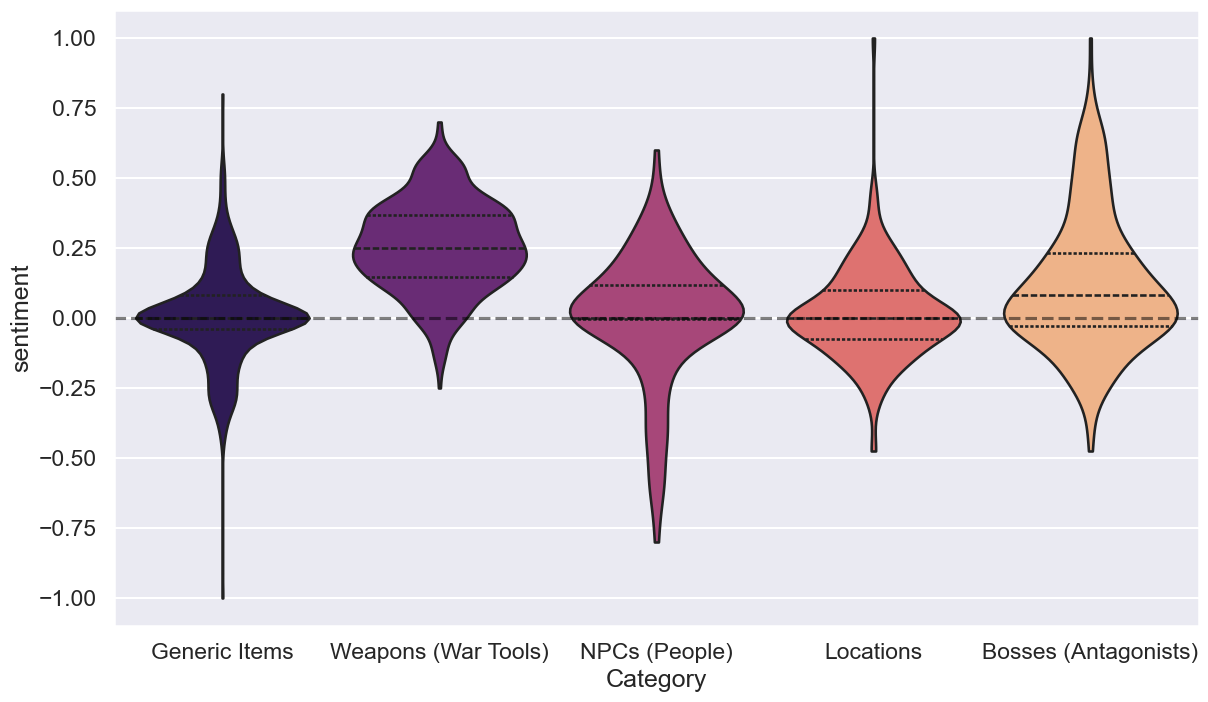

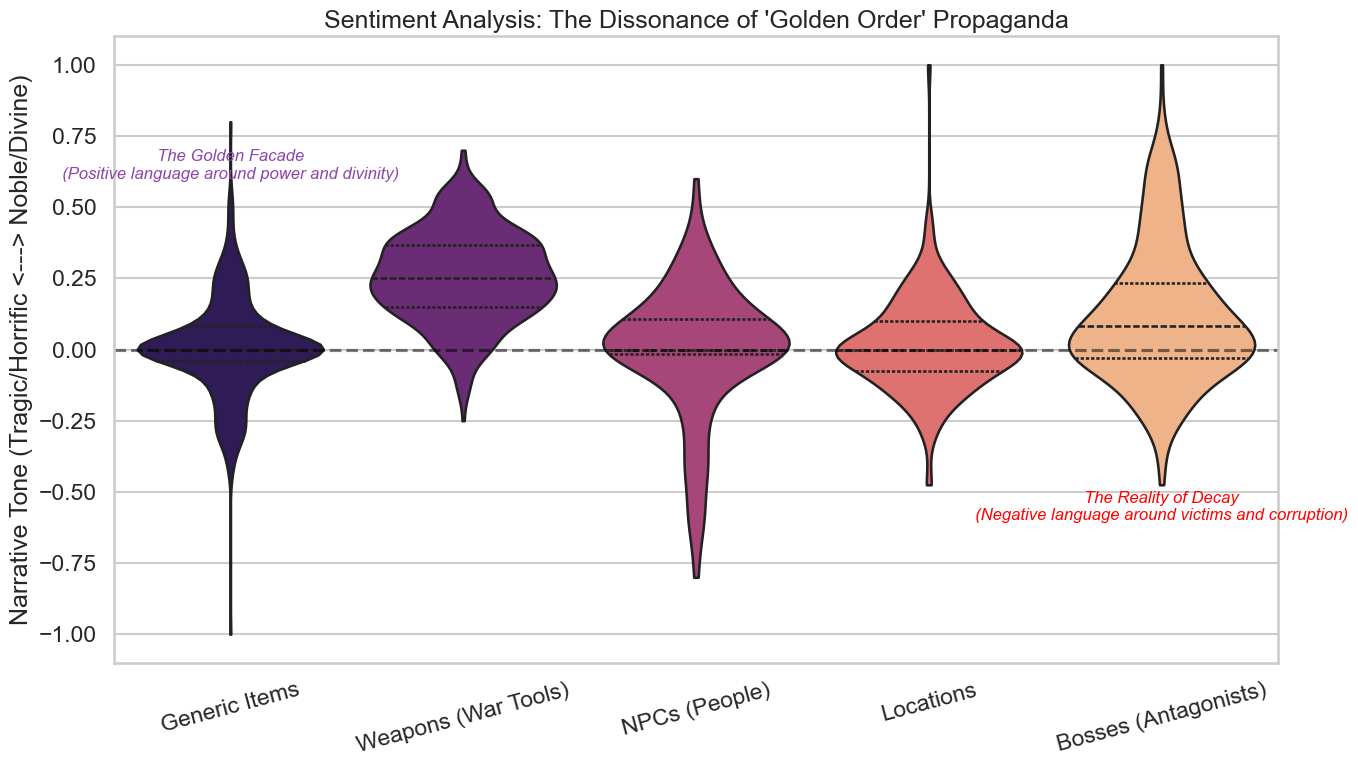

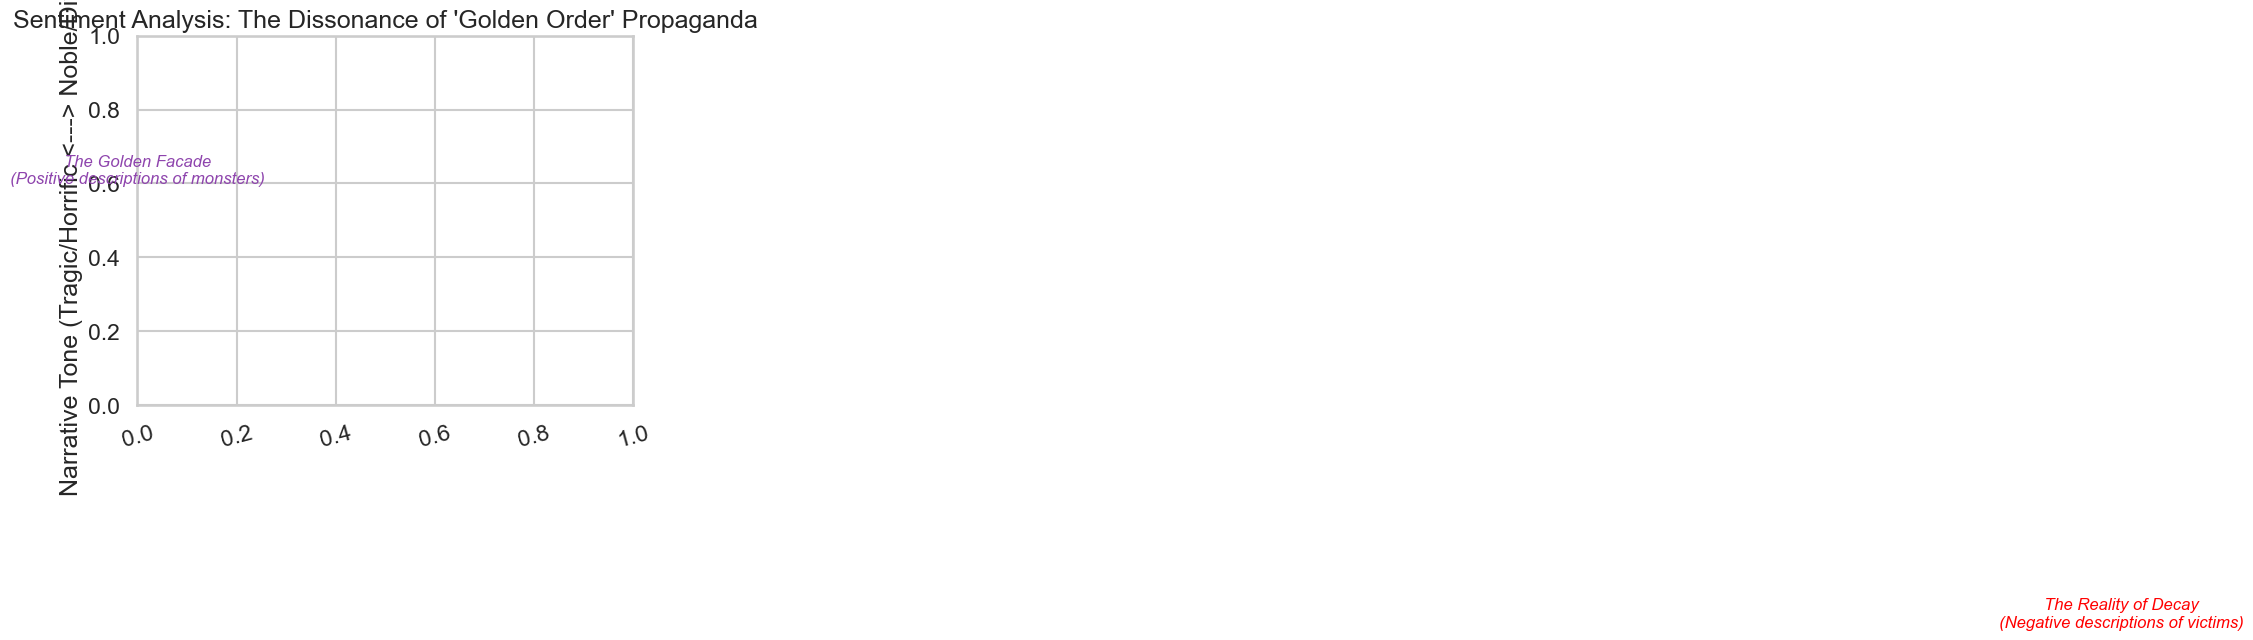

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from pathlib import Path

# 1. Load Data
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
# (We use the file you already have, which contains Community and Centrality)
df = pd.read_csv(PROCESSED_DIR / "nodes_analyzed.csv")

# -------------------------------------------------------
# CONSISTENCY FIX: APPLY SAME NOISE FILTER
# We remove generic categories to ensure sentiment reflects true lore.
# -------------------------------------------------------
noise_list = [
    # Stats & Mechanics
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Stats", "Runes", "Poison", "Scarlet Rot", "Status Effects",
    "Standard", "Pierce", "Slash", "Strike", 
    "Physical", "Magic", "Fire", "Lightning", "Holy",
    "Passive", "Skill", "Effect",
    
    # Item Categories (The "Gauntlets" Problem)
    "Armor", "Weapons", "Bosses", "Items", "Ash of War",
    "Gauntlets", "Greaves", "Helm", "Chest", "Legs", "Shield", 
    "Talisman", "Sorcery", "Incantation", "Spirit Ash",
    
    # Upgrades & Collectibles
    "Remembrance", "Memory Slot", "Talisman Pouch", "Golden Seed",
    "Sacred Tear", "Larval Tear", "Lost Ashes of War", "Smithing Stone",
    "Somber Smithing Stone", "Glovewort", "Bell Bearing",
    
    # World Terms
    "Shadow of the Erdtree", "The Lands Between"
]
df = df[~df['name'].isin(noise_list)]
print(f"Filtered Data: {len(df)} nodes remaining after noise removal.")

# 2. CRITICAL STEP: Calculate Sentiment
# The file from Notebook 03 doesn't have this column, so we must generate it here.
print("Calculating sentiment for visualization...")
def get_sentiment(text):
    # Handle missing or non-string values safely
    if pd.isna(text): return 0
    text_str = str(text)
    if len(text_str) < 5: return 0
    return TextBlob(text_str).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# 3. Filter for the relevant narrative categories
target_types = ['boss', 'weapon', 'npc', 'location', 'item']
plot_df = df[df['node_type'].isin(target_types)].copy()

# Rename for cleaner plot labels
type_map = {
    'boss': 'Bosses (Antagonists)',
    'weapon': 'Weapons (War Tools)',
    'npc': 'NPCs (People)',
    'location': 'Locations',
    'item': 'Generic Items'
}
plot_df['Category'] = plot_df['node_type'].map(type_map)

# 4. PLOT
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")
sns.set_context("talk")

# Violin Plot showing density of sentiment
ax = sns.violinplot(x='Category', y='sentiment', data=plot_df, 
                    palette="magma", inner="quartile", cut=0)

# Add Reference Line (Neutral)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

# Annotate the "Propaganda"import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from pathlib import Path

# 1. Load Data
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
df = pd.read_csv(PROCESSED_DIR / "nodes_analyzed.csv")

# -------------------------------------------------------
# 2. CONSISTENCY FIX: APPLY SAME NOISE FILTER
#    Remove generic mechanic/category nodes so sentiment reflects lore.
# -------------------------------------------------------
noise_list = [
    # Stats & mechanics
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane",
    "Stats", "Runes", "Poison", "Scarlet Rot", "Status Effects",
    "Standard", "Pierce", "Slash", "Strike",
    "Physical", "Magic", "Fire", "Lightning", "Holy",
    "Passive", "Skill", "Effect",

    # Item/categories and wiki headers
    "Armor", "Weapons", "Bosses", "Items", "Ashes of War", "Ash of War",
    "Gauntlets", "Greaves", "Helm", "Chest Armor", "Leg Armor",
    "Shield", "Talismans", "Talisman", "Sorceries", "Incantations",
    "Spirit Ashes", "Spirit Ash",
    "Builds", "Locations",

    # Upgrades & collectibles
    "Remembrance", "Memory Slot", "Talisman Pouch", "Golden Seed",
    "Sacred Tear", "Larval Tear", "Lost Ashes of War", "Smithing Stone",
    "Somber Smithing Stone", "Glovewort", "Bell Bearing",

    # World-level wiki pages
    "Shadow of the Erdtree", "The Lands Between"
]

df = df[~df["name"].isin(noise_list)]
print(f"Filtered Data: {len(df)} nodes remaining after noise removal.")

# -------------------------------------------------------
# 3. SENTIMENT (RECOMPUTE ON CLEANED DATA)
# -------------------------------------------------------
print("Calculating sentiment for visualization...")

def get_sentiment(text):
    if pd.isna(text):
        return 0.0
    text_str = str(text)
    if len(text_str) < 5:
        return 0.0
    return TextBlob(text_str).sentiment.polarity

df["sentiment"] = df["description"].apply(get_sentiment)

# -------------------------------------------------------
# 4. FILTER TO NARRATIVE TYPES
# -------------------------------------------------------
target_types = ["boss", "weapon", "npc", "location", "item"]
plot_df = df[df["node_type"].isin(target_types)].copy()

type_map = {
    "boss": "Bosses (Antagonists)",
    "weapon": "Weapons (War Tools)",
    "npc": "NPCs (People)",
    "location": "Locations",
    "item": "Generic Items"
}
plot_df["Category"] = plot_df["node_type"].map(type_map)

# -------------------------------------------------------
# 5. PLOT VIOLIN CHART
# -------------------------------------------------------
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.set_context("talk")

ax = sns.violinplot(
    x="Category",
    y="sentiment",
    data=plot_df,
    palette="magma",
    inner="quartile",
    cut=0
)

# Neutral reference line
plt.axhline(0, color="black", linestyle="--", alpha=0.5)

# Optional annotations – adjust positions after you see the plot
plt.text(
    0, 0.6,
    "The Golden Facade\n(Positive language around power and divinity)",
    color="#8e44ad",
    ha="center",
    fontsize=12,
    style="italic"
)

plt.text(
    4, -0.6,
    "The Reality of Decay\n(Negative language around victims and corruption)",
    color="red",
    ha="center",
    fontsize=12,
    style="italic"
)

plt.title("Sentiment Analysis: The Dissonance of 'Golden Order' Propaganda", fontsize=18)
plt.ylabel("Narrative Tone (Tragic/Horrific <---> Noble/Divine)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.text(0, 0.6, "The Golden Facade\n(Positive descriptions of monsters)", 
         color='#8e44ad', ha='center', fontsize=12, style='italic')

plt.text(4, -0.6, "The Reality of Decay\n(Negative descriptions of victims)", 
         color='red', ha='center', fontsize=12, style='italic')

plt.title("Sentiment Analysis: The Dissonance of 'Golden Order' Propaganda", fontsize=18)
plt.ylabel("Narrative Tone (Tragic/Horrific <---> Noble/Divine)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.show()

## The Tragedy of Commerce (Sociological Findings)

Analyzing the Economic Incentive for Violence...


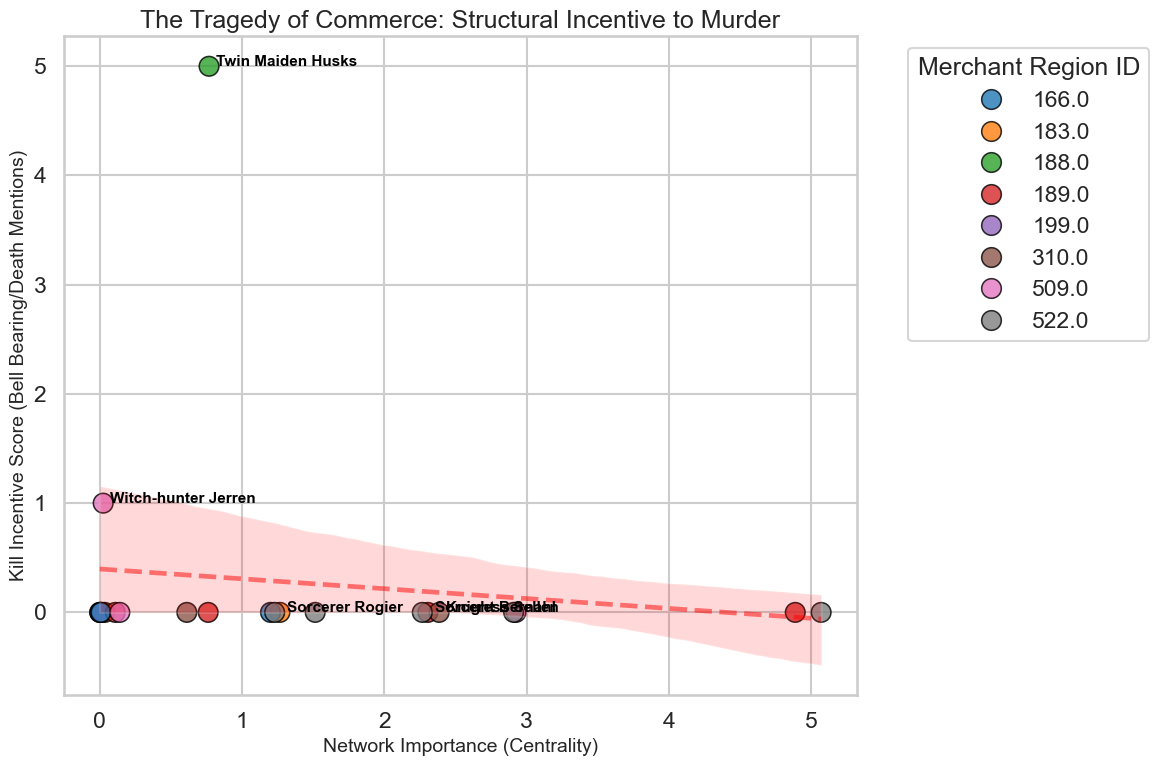

In [3]:
# ==========================================
# TRAGEDY OF COMMERCE: THE OPTIMIZATION OF MURDER
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print("Analyzing the Economic Incentive for Violence...")

# 1. IDENTIFY MERCHANTS MORE ROBUSTLY
# Filter for nodes that are typed as 'npc' AND have 'merchant' or 'bell bearing' in their text
# This catches named merchants (like Kalé) even if their name doesn't say "Merchant"
merchant_mask = (
    (df['node_type'] == 'npc') & 
    (df['description'].str.contains('merchant|sell|shop|bell bearing', case=False, na=False))
)
merchants_df = df[merchant_mask].copy()

# 2. CALCULATE "KILL INCENTIVE"
# We look specifically for "Bell Bearing" because that is the mechanic that rewards murder.
# We also look for "Corpse" or "Die" to see if the game lore frames them as victims.
kill_keywords = ['bell bearing', 'hunter', 'killed', 'slaughter', 'robbed', 'dead', 'drops']

def calculate_tragedy_score(text):
    if pd.isna(text): return 0
    text = str(text).lower()
    score = 0
    # Higher weight for the mechanical reward (Bell Bearing)
    if 'bell bearing' in text: score += 3 
    # Lower weight for general tragedy
    score += sum(1 for w in kill_keywords if w in text)
    return score

merchants_df['kill_incentive'] = merchants_df['description'].apply(calculate_tragedy_score)

# 3. NORMALIZE CENTRALITY FOR PLOTTING
# Scale centrality so we can see the differences
merchants_df['centrality_scaled'] = merchants_df['centrality'] * 1000

# 4. PLOT: The "Cost of Business" Scatter
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create Scatter Plot
scatter = sns.scatterplot(
    data=merchants_df, 
    x='centrality_scaled', 
    y='kill_incentive',
    hue='community', # Color by Faction (shows if some regions are safer)
    palette='tab10',
    s=200, # Big dots
    alpha=0.8,
    edgecolor='black'
)

# 5. ANNOTATE THE MOST "VALUABLE" VICTIMS
# Label the merchants who are high-value targets (High Centrality + High Kill Score)
top_targets = merchants_df.nlargest(5, 'kill_incentive')
for _, row in top_targets.iterrows():
    plt.text(
        row['centrality_scaled'] + 0.05, 
        row['kill_incentive'], 
        row['name'], 
        fontsize=11, 
        fontweight='bold',
        color='black'
    )

# Add Trend Line (Optional, but looks cool)
sns.regplot(
    data=merchants_df, 
    x='centrality_scaled', 
    y='kill_incentive', 
    scatter=False, 
    color='red', 
    line_kws={'linestyle': '--', 'alpha': 0.5}
)

plt.title("The Tragedy of Commerce: Structural Incentive to Murder", fontsize=18)
plt.xlabel("Network Importance (Centrality)", fontsize=14)
plt.ylabel("Kill Incentive Score (Bell Bearing/Death Mentions)", fontsize=14)

# Custom Legend
plt.legend(title='Merchant Region ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
